In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/books-amazon-product-data/ratings_Books.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.decomposition import TruncatedSVD

importing data

In [3]:
path = Path('/kaggle/input/books-amazon-product-data/ratings_Books.csv')
df = pd.read_csv(path,names=['user', 'product','rating','timestamp'])

checking head() and shape

In [4]:
df.head(),df.shape

(             user     product  rating   timestamp
 0   AH2L9G3DQHHAJ  0000000116     4.0  1019865600
 1  A2IIIDRK3PRRZY  0000000116     1.0  1395619200
 2  A1TADCM7YWPQ8M  0000000868     4.0  1031702400
 3   AWGH7V0BDOJKB  0000013714     4.0  1383177600
 4  A3UTQPQPM4TQO0  0000013714     5.0  1374883200,
 (22507155, 4))

Chechking for null, NaN data and column datatypes

In [5]:
df.info(),df.isnull().sum(),df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22507155 entries, 0 to 22507154
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user       object 
 1   product    object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 686.9+ MB


(None,
 user         0
 product      0
 rating       0
 timestamp    0
 dtype: int64,
 user         0
 product      0
 rating       0
 timestamp    0
 dtype: int64)

So far, so good

Now, we can focus on recommendations based on high demand and rating regardless of the purchase history. We need this to prevent offer same items again and again , based on the user history, and for the users who has no history at all.

In [6]:
dfmr = df.head(1000000)

In [7]:
dfmr = dfmr.groupby('product').filter(lambda x:x['rating'].count() >=1000)

In [8]:
dfmr.shape

(183204, 4)

In [9]:
df_top = pd.DataFrame(dfmr.groupby('product')['rating'].mean())
df_top.head()

,rating
product,
0002007770,4.398934
0002247399,3.796694
0006514006,4.318261
0007124015,4.633418
0007205236,4.403127


In [10]:
df_top['NtimesRated'] = pd.DataFrame(dfmr.groupby('product')['rating'].count())
df_top

,rating,NtimesRated
product,,
0002007770,4.398934,6001
0002247399,3.796694,6473
0006514006,4.318261,1150
0007124015,4.633418,4321
0007205236,4.403127,1471
...,...,...
006222543X,4.198523,1219
0062255657,4.174059,2976
006226768X,4.019742,1165


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


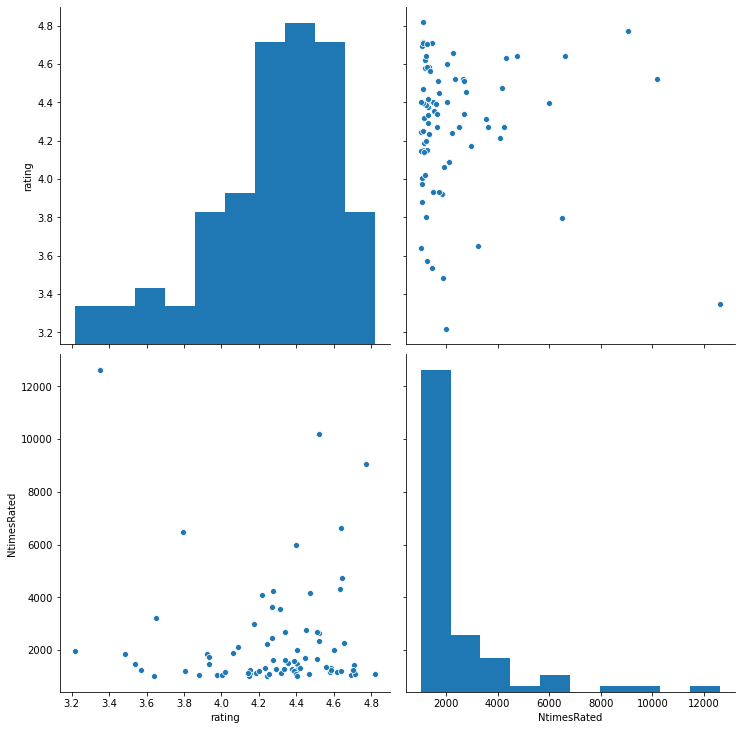

In [11]:
 sns.pairplot(df_top[['rating','NtimesRated']],size=5)

Most popular products always have a decent rating (3.5 or 4.0), that's a good start for our query.

In [12]:
df_top_1 = df_top[df_top['rating'] > 4.0]

In [13]:
df_top_1
df_top_1.shape

(65, 2)

In [14]:
topsellers = df_top_1.NtimesRated.sort_values(ascending=False)
topsellers.shape

(65,)

In [15]:
topsellers

product
0007442920    10172
0007386648     9062
0061950726     6612
0002007770     6001
0061537934     4736
              ...  
0007281447     1072
006218850X     1040
0062217208     1013
0061147958     1011
0007493754     1001
Name: NtimesRated, Length: 65, dtype: int64

you can query Amazon API with the product identification number to get the idea what that items are

for example:

In [16]:
import webbrowser
prodid = topsellers.index[0]
webpath = 'https://www.amazon.com/dp/'+prodid

In [17]:
webbrowser.open(webpath)

False

your web browser should open locally that page . you would need an Amazon API key for real queries tho

COLLABORATIVE FILTERING

In [18]:
cf_df = dfmr.sample(20000)
cf_df.shape

(20000, 4)

In [19]:
cf_df_r = cf_df.pivot_table(index='user',values='rating',columns='product',fill_value=0)
cf_df_r_T = cf_df_r.T

**calculating Truncated SVD**

run svd once to get the initial parameters to calculate components

In [20]:
SVD = TruncatedSVD(n_components=(cf_df_r_T.shape[1]-1)//2)

In [21]:
X_SVD = SVD.fit(cf_df_r_T)

In [22]:
#creating list of explained variances
SVD_exp_var = SVD.explained_variance_ratio_

now we need to calculate number of components for the svd.

In [23]:
def calc_numb(exp_vars,final_ratio):
    total_vars = 0.0
    n_components = 0
    for explained_variance in exp_vars:
        total_vars += explained_variance
        n_components += 1
        if total_vars >= final_ratio:
            break
    return n_components

In [24]:
components = calc_numb(SVD_exp_var,0.9)
components

62

In [25]:
SVD_1 = TruncatedSVD(n_components=components)

In [26]:
decomposed_matrix = SVD_1.fit_transform(cf_df_r_T)

In [27]:
decomposed_matrix.shape

(80, 62)

In [28]:
corr_matrix = np.corrcoef(decomposed_matrix)
corr_matrix.shape

(80, 80)

we got matrix of product indexes, now we can query any product and get relation 

In [29]:
ind1 = cf_df_r_T.index[74]
prod_names = list(cf_df_r_T.index)
prod_id = prod_names.index(ind1)
prod_id,ind1

(74, '0062217208')

In [30]:
corr_prod_ids = corr_matrix[prod_id]
corr_prod_ids.shape

(80,)

Recommending highly correlated products in sequence

In [31]:
reclist = list(cf_df_r_T.index[corr_prod_ids > 0.5])
reclist.remove(ind1)

In [32]:
reclist

['0061147931']

and we can check what kind of product is that .

In [33]:
webpath1 = 'https://www.amazon.com/dp/'+ind1
webbrowser.open(webpath1)

False

![](https://images-na.ssl-images-amazon.com/images/I/51I3O9EGDQL._SX330_BO1,204,203,200_.jpg)

and we can check recommendations in the exact same way

![](https://images-na.ssl-images-amazon.com/images/I/51-zJEmZn8L._SX324_BO1,204,203,200_.jpg)
![](https://images-na.ssl-images-amazon.com/images/I/51FUkRLXLsL._SX328_BO1,204,203,200_.jpg)
![](https://images-na.ssl-images-amazon.com/images/I/51gREdA2jqL._SX329_BO1,204,203,200_.jpg)
![](https://images-na.ssl-images-amazon.com/images/I/512rYFkWCCL._SX329_BO1,204,203,200_.jpg)
![](https://images-na.ssl-images-amazon.com/images/I/51p3FIHUcfL._SX329_BO1,204,203,200_.jpg)